# import packs

In [1]:
import pandas as pd
# für Handhabung von Dateipfade
import os
from os import path
import re
from collections import Counter
# für url Zugang zu stopwords liste von github
import requests
import nltk
from nltk.tokenize import word_tokenize 
from statistics import mean, median
#tei reader
from tei_reader import TeiReader
reader = TeiReader()
# music21
from music21 import *
# Visualisierung
import numpy as np
import matplotlib.pyplot as plt

# read in csv file (Text)

In [2]:
df = pd.read_csv("/Users/amiip/Desktop/2023W/SE_Masterarbeit/Fruelingslieder.csv", sep=';')
#df

#### Kombinieren der Textspalten und erstellen von neuer Spalte namens "Lyrics"

In [3]:
df = df.applymap(str)
# Entfernen von NaN-Werten aus den ausgewählten Spalten
df[['Refrain', 'Strophe_1', 'Strophe_2', 'Strophe_3']] = df[['Refrain', 'Strophe_1', 'Strophe_2', 'Strophe_3']].replace('nan', '')

# Zusammenführen von Text-Spalten
df['Lyrics'] = df[['Refrain', 'Strophe_1', 'Strophe_2', 'Strophe_3']].apply(lambda x: ' '.join(x), axis=1)
texts = df["Lyrics"].sum()

## Clean texts and remove stop words:

In [4]:
cleaned_texts = texts.lower()
cleaned_texts = re.sub("\:", " ", cleaned_texts) # get rid of :
cleaned_texts = re.sub("\;", " ", cleaned_texts) # get rid of ;
cleaned_texts = re.sub("\'", "", cleaned_texts) # get rid of '
cleaned_texts = re.sub("\...", "", cleaned_texts) # get rid of ...
cleaned_texts = re.sub('\.','', cleaned_texts) # get rid of .
cleaned_texts = re.sub("\,", "", cleaned_texts) # get rid of ,
cleaned_texts = re.sub("\!", " ", cleaned_texts) # get rid of !
cleaned_texts = re.sub("\?", " ", cleaned_texts) # get rid of ?
cleaned_texts = re.sub('\„', ' ', cleaned_texts) # get rid of „
cleaned_texts = re.sub("\“", " ", cleaned_texts) # get rid of “
cleaned_texts = re.sub('\"', " ", cleaned_texts) # get rid of "
cleaned_texts = re.sub('\-', " ", cleaned_texts) # get rid of -
cleaned_texts = re.sub(' +',' ', cleaned_texts) # get rid of multiple spaces
print(len(cleaned_texts))
#print(cleaned_texts)

12219


In [5]:
# URL zur Stoppwortliste auf GitHub
url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-de/master/stopwords-de.txt'

# Herunterladen der Stoppwortliste
response = requests.get(url)
if response.status_code == 200:
    stopwords_text = response.text
    stopwords = stopwords_text.split('\n')  # Teilen Sie den Text in Zeilen auf, um eine Liste von Stoppwörtern zu erhalten
    stopwords_set = set(stopwords)  # Optional: Umwandeln in ein Set für eine schnellere Suche
else:
    print("Fehler beim Herunterladen der Stoppwortliste.")

# Entfernen von Wörtern aus der Stoppwortliste
words_to_remove = ["bald", "besonders", "bisher", "dich", "dir", "du", "ehrlich", "ernst", "früher", "gern", "gut", "gute", "guter", "gutes", "heute", "ich", "kurz", "lang", "lange", "leide", "lieber", "mich", "mir", "mögen", "mögt", "nein", "richtig", "schlecht", "uns", "unser", "unsere", "unserer", "wahr"]
if words_to_remove in stopwords:
    stopwords.remove(words_to_remove)

# Zusätzliche Wörter, die entfernt werden sollen
additional_stopwords = ["ans", "des", "dös", "für", "fürs", "fürn", "grad", "is", "san", "sinds", "wirds", "mei"]
stopwords += additional_stopwords

#print(stopwords[:10])

### Tokenize text

In [6]:
word_tokens = word_tokenize(cleaned_texts) 
    
filtered_list = [] 
for w in word_tokens: 
    if w not in stopwords: 
        filtered_list.append(w) 
#filtered_list

list_words = cleaned_texts.split()
list_words = [l.strip().lower() for l in filtered_list]
#list_words[100:110]

### Finding and counting word occurences:

In [7]:
# Zählen von Worthäufigkeiten
freqdist = Counter(list_words)
freqdist.most_common(10)

[('frühling', 31),
 ('liebe', 18),
 ('wien', 10),
 ('prater', 8),
 ('wein', 8),
 ('heut', 8),
 ('welt', 8),
 ('rhein', 8),
 ('herzen', 7),
 ('herz', 7)]

In [8]:
import re
from collections import defaultdict

# Muster für die Wörter und ihre Variationen
word_patterns = {
    'frühling': r'\w*frühling\w*',
    'liebe': r'\w*lieb\w*',
    'herz': r'\w*herz\w*',
    'sonne': r'\w*sonn\w*',
    'küssen': r'\w*kü(ß|ss|st|s\w*)\w*',
    'blühen': r'\w*blüh\w*',
    'glück': r'\w*glück\w*',
    'wien': r'\w*wien\w*',
    'prater': r'\w*prater\w*', 
    'musik': r'\w*musi(k|c)\w*'
}

# Dictionary zur Speicherung der Treffer pro Lied
lied_treffer = defaultdict(int)

# Iteriere durch die DataFrame-Zeilen und suche nach den Mustern in den Texten
for index, row in df.iterrows():
    # Bereinige und kombiniere alle relevanten Texte in einem Lied
    text = ' '.join([row['Refrain'], row['Strophe_1'], row['Strophe_2'], row['Strophe_3']])
    cleaned_text = re.sub(r'[^\w\s]', '', text.lower())  # Satzzeichen entfernen und klein schreiben

    # Überprüfe für jedes Wortmuster, ob es im aktuellen Text vorkommt
    for word, pattern in word_patterns.items():
        if re.search(pattern, cleaned_text):
            lied_treffer[word] += 1

# Ergebnisse anzeigen
print("\nAnzahl der Lieder, die die angegebenen Wörter inklusive Variationen enthalten:")
for word, count in lied_treffer.items():
    print(f"{word}: {count} Lieder")



Anzahl der Lieder, die die angegebenen Wörter inklusive Variationen enthalten:
frühling: 15 Lieder
sonne: 4 Lieder
küssen: 9 Lieder
blühen: 5 Lieder
wien: 6 Lieder
prater: 4 Lieder
musik: 4 Lieder
herz: 9 Lieder
liebe: 11 Lieder
glück: 8 Lieder


In [9]:
# Funktion für Wortgruppen basierend auf ihren stems
def normalize_by_stem(word_list, stems):
    normalized_list = []
    for word in word_list:
        normalized_word = replace_stem_words(word, stems)
        normalized_list.append(normalized_word)
    return normalized_list

def replace_stem_words(word, stems):
    for stem, pattern in stems.items():
        if re.search(pattern, word, flags=re.IGNORECASE):
            return stem
    return word

# Definieren von stems für häufige Wörter
stems = {
    'lieb': r'lieb\w*|liab\w*',
    'leid': r'leid\w*',
    'mag': r'mag\w*|mög\w*',
    'herz': r'herz\w*',
    'wien': r'wien\w*',
    'traum': r'traum\w*|träum\w*',
    'frühling': r'frühling\w*',
    'musik': r'musik\w*',
    'glück': r'glück\w*',
    'wein': r'wein\w*',
    'schön': r'\w*schön\w*',
    'küß': r'küß\w*|küss\w*',
    'heut': r'heut\w*',
    'gut': r'gut\w*',
    'lach': r'lach\w*',
    'kling': r'kling\w*',
    'sing': r'sing\w*',
    'prater': r'prater\w*',
    'baum': r'baum\w*|bäum\w*',
    'vogerl': r'voge\w*|vöge\w*|vögl\w*',
    'tanz': r'\w*tanz\w*|tänz\w*',
    'nacht': r'nacht\w*|nächt\w*',
    'mutter': r'mutter\w*',
    'sonne': r'sonne\w*',
    'süß': r'süß\w*',
    'kind': r'kind\w*'
}

# Upgedatete stems
normalized_words = normalize_by_stem(filtered_list, stems)

# Worthäufigkeiten berechnen mit upgedateten stems
freqdist = Counter(normalized_words)
common_words = freqdist.most_common(100)
common_words

[('lieb', 38),
 ('frühling', 36),
 ('herz', 18),
 ('wien', 15),
 ('wein', 14),
 ('glück', 13),
 ('küß', 12),
 ('prater', 10),
 ('sing', 10),
 ('kling', 9),
 ('traum', 8),
 ('heut', 8),
 ('welt', 8),
 ('rhein', 8),
 ('tanz', 7),
 ('schön', 7),
 ('mutter', 5),
 ('lach', 5),
 ('musik', 5),
 ('mai', 5),
 ('paar', 5),
 ('zieht', 5),
 ('weiß', 5),
 ('augen', 5),
 ('amsterdam', 5),
 ('baum', 4),
 ('marie', 4),
 ('frau', 4),
 ('sonne', 4),
 ('süß', 4),
 ('haus', 4),
 ('selig', 4),
 ('mädel', 4),
 ('lebe', 4),
 ('bacharach', 4),
 ('ruft', 4),
 ('grün', 3),
 ('kind', 3),
 ('net', 3),
 ('sitzt', 3),
 ('wär', 3),
 ('lied', 3),
 ('sagen', 3),
 ('siehst', 3),
 ('nacht', 3),
 ('schließ', 3),
 ('leise', 3),
 ('treu', 3),
 ('hell', 3),
 ('vogerl', 3),
 ('ringsumher', 3),
 ('blühn', 2),
 ('sievering', 2),
 ('seligen', 2),
 ('raus', 2),
 ('guck', 2),
 ('weißes', 2),
 ('leid', 2),
 ('fahrn', 2),
 ('langsam', 2),
 ('bitt', 2),
 ('erblühn', 2),
 ('vis', 2),
 ('johann', 2),
 ('knien', 2),
 ('gestern', 2),
 (

# Visualizing my results

### Barplot:

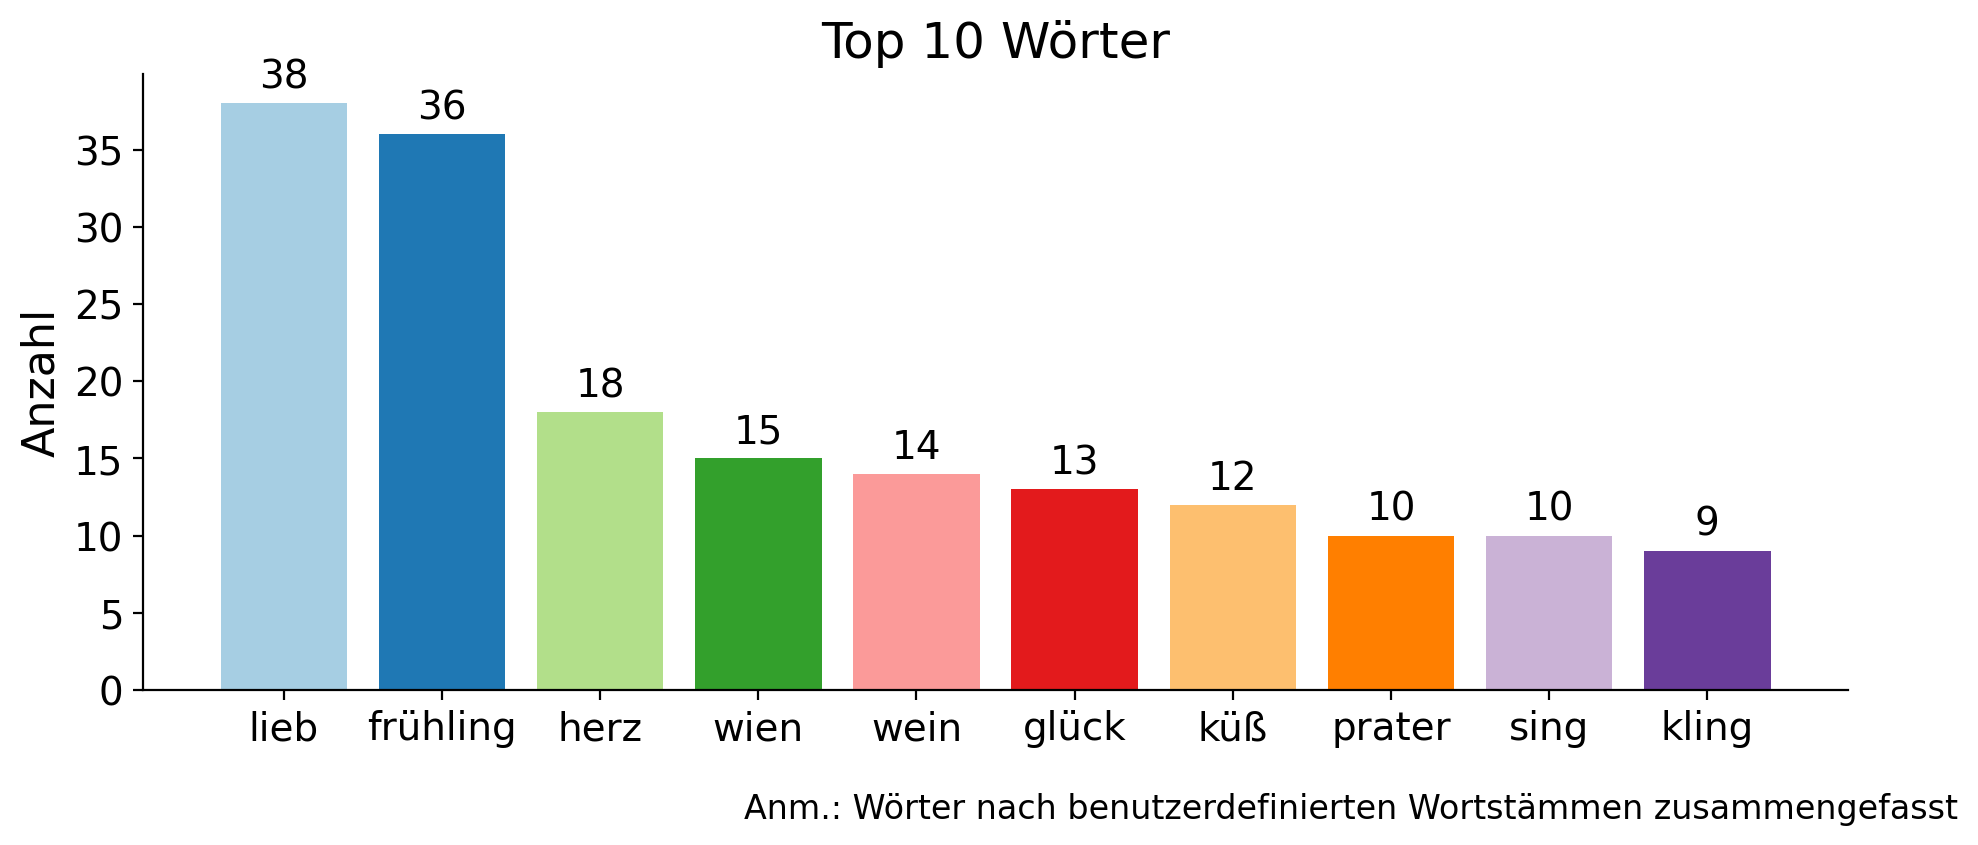

In [10]:
import numpy as np
import matplotlib.pyplot as plt

labels, values = zip(*freqdist.most_common(10))

indexes = np.arange(len(labels))

colors = ['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

plt.bar(indexes, values, color=colors)
fig = plt.gcf()
fig.set_size_inches(11, 4)
plt.xticks(indexes, labels, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Top 10 Wörter", fontsize=18)
plt.ylabel("Anzahl", fontsize=16)
# Entfernen der oberen und rechten Rahmenlinien (Spines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Anzahl der Vorkommen über jedem Balken anzeigen
for i, value in enumerate(values):
    plt.text(indexes[i], value + 0.5, str(value), ha='center', va='bottom', fontsize=14)

# Notiz/Quelle unterhalb des Plots hinzufügen
plt.figtext(0.95, -0.05, "Anm.: Wörter nach benutzerdefinierten Wortstämmen zusammengefasst", 
            horizontalalignment='right', fontsize=12)

# Speichern der Grafik
#plt.savefig('top_10_woerter.png', dpi=300, bbox_inches='tight')
plt.show()

### Wordcloud:

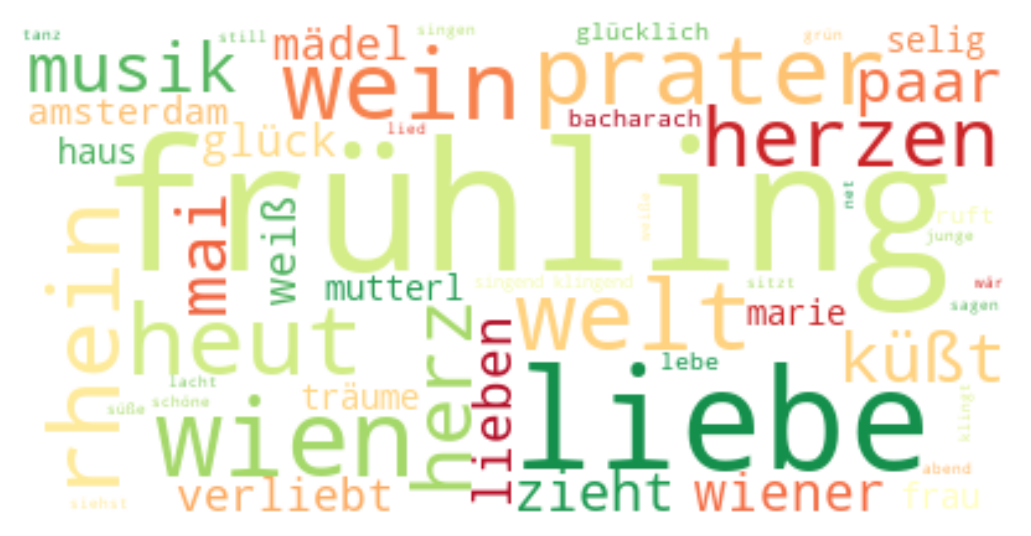

In [12]:
from wordcloud import WordCloud

cleaned = ' '.join(list_words)
wordcloud = WordCloud(max_words = 50, background_color="white", colormap="RdYlGn").generate(cleaned)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
#wordcloud.to_file("top50_wordcloud.png")